## Background
Since this is my first object detection competition in Kaggle, I am mainly using it for learning. There are great kernel here, mostly using the FastRCNN model And I have learned how to prepare the data and use it with this popular model.I have decided to build a learning kernel, that at least at the beginning will explain the topic and the concepts, the definition and the basics. I will explain every important code line.

## IF you like this kernel, Please upvote

# Introduction

Welcome to the "Global Wheat Detection" competition! In this competition, contestent will detect wheat heads from outdoor images of wheat plants, including wheat datasets from around the globe. Using worldwide data, contestent will focus on a generalized solution to estimate the number and size of wheat heads. To better gauge the performance for unseen genotypes, environments, and observational conditions, the training dataset covers multiple regions. contestent will use more than 3,000 images from Europe (France, UK, Switzerland) and North America (Canada). The test data includes about 1,000 images from Australia, Japan, and China.

# Acknowledgements

1. PYTORCH TORCHVISION OBJECT DETECTION FINETUNING TUTORIAL [https://pytorch.org/tutorials/intermediate/torchvision_tutorial.html](http://)
2. GREAT KERNEL BY nvnn [https://www.kaggle.com/nvnnghia/fasterrcnn-pseudo-labeling](http://)
3. Pretrained weight [https://www.kaggle.com/mathurinache/fasterrcnn](http://)
4. Fast RCNN : https://towardsdatascience.com/faster-rcnn-object-detection-f865e5ed7fc4

# Content
### 1.EDA
### 2. Writing a custom dataset for our work
### 3. Define the model
### 4. Finetuning from a pretrained model
### 5. Prediction
### 6. End Note

# 1.EDA

### Install and import necessary libraries

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np  # linear algebra
import pandas as pd  # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os

for dirname, _, filenames in os.walk('C:/Users/allex/PycharmProjects/PyTorchTest/iava_labs/kaggle'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

C:/Users/allex/PycharmProjects/PyTorchTest/iava_labs/kaggle\fasterrcnn_resnet50_fpn_best.pth
C:/Users/allex/PycharmProjects/PyTorchTest/iava_labs/kaggle\sample_submission.csv
C:/Users/allex/PycharmProjects/PyTorchTest/iava_labs/kaggle\train.csv
C:/Users/allex/PycharmProjects/PyTorchTest/iava_labs/kaggle\test\2fd875eaa.jpg
C:/Users/allex/PycharmProjects/PyTorchTest/iava_labs/kaggle\test\348a992bb.jpg
C:/Users/allex/PycharmProjects/PyTorchTest/iava_labs/kaggle\test\51b3e36ab.jpg
C:/Users/allex/PycharmProjects/PyTorchTest/iava_labs/kaggle\test\51f1be19e.jpg
C:/Users/allex/PycharmProjects/PyTorchTest/iava_labs/kaggle\test\53f253011.jpg
C:/Users/allex/PycharmProjects/PyTorchTest/iava_labs/kaggle\test\796707dd7.jpg
C:/Users/allex/PycharmProjects/PyTorchTest/iava_labs/kaggle\test\aac893a91.jpg
C:/Users/allex/PycharmProjects/PyTorchTest/iava_labs/kaggle\test\cb8d261a3.jpg
C:/Users/allex/PycharmProjects/PyTorchTest/iava_labs/kaggle\test\cc3532ff6.jpg
C:/Users/allex/PycharmProjects/PyTorchTest/i

In [2]:
import cv2
import os
import re
import torch
import torchvision
from torchvision import transforms
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator
from torch.utils.data import DataLoader, Dataset
from torch.utils.data.sampler import SequentialSampler
from matplotlib import pyplot as plt

In [3]:
WEIGHTS_FILE = 'C:/Users/allex/PycharmProjects/PyTorchTest/iava_labs/kaggle/fasterrcnn_resnet50_fpn_best.pth'

###  Load train and test file

In [4]:
train_df = pd.read_csv("./kaggle/train.csv")
submit = pd.read_csv("./kaggle/sample_submission.csv")

In [55]:
train_df.head()

,image_id,width,height,bbox,source
0,b6ab77fd7,1024,1024,"[834.0, 222.0, 56.0, 36.0]",usask_1
1,b6ab77fd7,1024,1024,"[226.0, 548.0, 130.0, 58.0]",usask_1
2,b6ab77fd7,1024,1024,"[377.0, 504.0, 74.0, 160.0]",usask_1
3,b6ab77fd7,1024,1024,"[834.0, 95.0, 109.0, 107.0]",usask_1
4,b6ab77fd7,1024,1024,"[26.0, 144.0, 124.0, 117.0]",usask_1


In [56]:
train_df = train_df.drop(columns=['width', 'height', 'source'])  #Drop unwanted columns

In [57]:
train_df['image_id'].nunique()  # There are total 3373 unique image in training dataset

3373

In [58]:
(train_df['image_id'].value_counts()).max()  # maximum number of boxes in a single image are 116

116

In [59]:
(train_df['image_id'].value_counts()).min()  # Minimum number of box in a single image is 1

1

### Splitting the dimension of box in the formate [xmin, ymin, w, h]
#### Latter on we will convert the deminsion of box into [xmin, ymin, xmax, ymax] in 

In [5]:
train_df['x'] = -1
train_df['y'] = -1
train_df['w'] = -1
train_df['h'] = -1


def expand_bbox(x):
    r = np.array(re.findall("([0-9]+[.]?[0-9]*)", x))
    if len(r) == 0:
        r = [-1, -1, -1, -1]
    return r

In [6]:
train_df[['x', 'y', 'w', 'h']] = np.stack(
    train_df['bbox'].apply(lambda x: expand_bbox(x)))  ##Lets convert the Box in  our desired formate 
train_df['x'] = train_df['x'].astype(float)
train_df['y'] = train_df['y'].astype(float)
train_df['w'] = train_df['w'].astype(float)
train_df['h'] = train_df['h'].astype(float)

In [62]:
train_df.head()

,image_id,bbox,x,y,w,h
0,b6ab77fd7,"[834.0, 222.0, 56.0, 36.0]",834.0,222.0,56.0,36.0
1,b6ab77fd7,"[226.0, 548.0, 130.0, 58.0]",226.0,548.0,130.0,58.0
2,b6ab77fd7,"[377.0, 504.0, 74.0, 160.0]",377.0,504.0,74.0,160.0
3,b6ab77fd7,"[834.0, 95.0, 109.0, 107.0]",834.0,95.0,109.0,107.0
4,b6ab77fd7,"[26.0, 144.0, 124.0, 117.0]",26.0,144.0,124.0,117.0


### Splitting the data into train and validation set

In [7]:
image_ids = train_df['image_id'].unique()
valid_ids = image_ids[-665:]
train_ids = image_ids[:-665]

valid_df = train_df[train_df['image_id'].isin(valid_ids)]
train_df = train_df[train_df['image_id'].isin(train_ids)]

# test_procentage = 0.1
# 
# valid_df = valid_df.sample(frac=test_procentage, random_state=42)
# train_df = train_df.sample(frac=test_procentage, random_state=42)


In [8]:
train_df['image_id'].nunique()

2708

In [9]:
trans = transforms.Compose([transforms.ToTensor()])  #Apply transform to image 

# 2.Writing a custom dataset for our work

### 2.1 Writing a custom dataset for train and validation images

In [66]:
records = train_df[train_df['image_id'] == "b6ab77fd7"]
boxes = records[['x', 'y', 'w', 'h']].values.astype(float)
boxes[:, 2] = boxes[:, 0] + boxes[:, 2]
boxes[:, 3] = boxes[:, 1] + boxes[:, 3]
boxes = torch.as_tensor(boxes, dtype=torch.float32)

area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
area = torch.as_tensor(area, dtype=torch.float32)

target = {}
target['boxes'] = boxes
target['area'] = area

target

{'boxes': tensor([[575., 146., 647., 267.],
         [834., 222., 890., 258.],
         [583., 329., 663., 412.],
         [175., 866., 257., 909.],
         [160., 689., 300., 763.]]),
 'area': tensor([ 8712.,  2016.,  6640.,  3526., 10360.])}

In [10]:
class WheatDataset(Dataset):

    def __init__(self, dataframe, image_dir, transforms=None, train=True):
        super().__init__()

        self.df = dataframe
        self.image_ids = dataframe['image_id'].unique()
        self.image_dir = image_dir
        self.transforms = transforms
        self.train = train

    def __len__(self) -> int:
        return self.image_ids.shape[0]

    def __getitem__(self, index: int):

        image_id = self.image_ids[index]
        image = cv2.imread(f'{self.image_dir}/{image_id}.jpg', cv2.IMREAD_COLOR)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)
        image /= 255.0
        if self.transforms is not None:  #Apply transformation
            image = self.transforms(image)
        if (self.train == False):  # For test data
            return image, image_id
        #Else for train and validation data
        records = self.df[self.df['image_id'] == image_id]
        boxes = records[['x', 'y', 'w', 'h']].values.astype(float)
        boxes[:, 2] = boxes[:, 0] + boxes[:, 2]
        boxes[:, 3] = boxes[:, 1] + boxes[:, 3]
        boxes = torch.as_tensor(boxes, dtype=torch.float32)

        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        area = torch.as_tensor(area, dtype=torch.float32)

        # there is only one class
        labels = torch.ones((records.shape[0],), dtype=torch.int64)

        # suppose all instances are not crowd
        iscrowd = torch.zeros((records.shape[0],), dtype=torch.int64)

        target = {}
        target['boxes'] = boxes
        target['labels'] = labels
        target['image_id'] = torch.tensor([index])
        target['area'] = area
        target['iscrowd'] = iscrowd

        return image, target, image_id

In [11]:
train_dir = './kaggle/train'
test_dir = './kaggle/test'

In [12]:
class Averager:  ##Return the average loss 
    def __init__(self):
        self.current_total = 0.0
        self.iterations = 0.0

    def send(self, value):
        self.current_total += value
        self.iterations += 1

    @property
    def value(self):
        if self.iterations == 0:
            return 0
        else:
            return 1.0 * self.current_total / self.iterations

    def reset(self):
        self.current_total = 0.0
        self.iterations = 0.0


def collate_fn(batch):
    return tuple(zip(*batch))


train_dataset = WheatDataset(train_df, train_dir, trans, True)
valid_dataset = WheatDataset(valid_df, train_dir, trans, True)

# split the dataset in train and test set
indices = torch.randperm(len(train_dataset)).tolist()

train_data_loader = DataLoader(
    train_dataset,
    batch_size=16,
    shuffle=False,
    # num_workers=4,
    collate_fn=collate_fn
)

valid_data_loader = DataLoader(
    valid_dataset,
    batch_size=8,
    shuffle=False,
    # num_workers=4,
    collate_fn=collate_fn
)

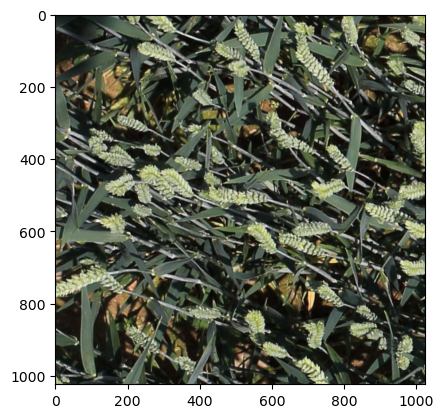

In [70]:
plt.imshow(train_dataset.__getitem__(0)[0].permute(1, 2, 0))
plt.show()

### Lets visualize some of the images with bounding box

In [17]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


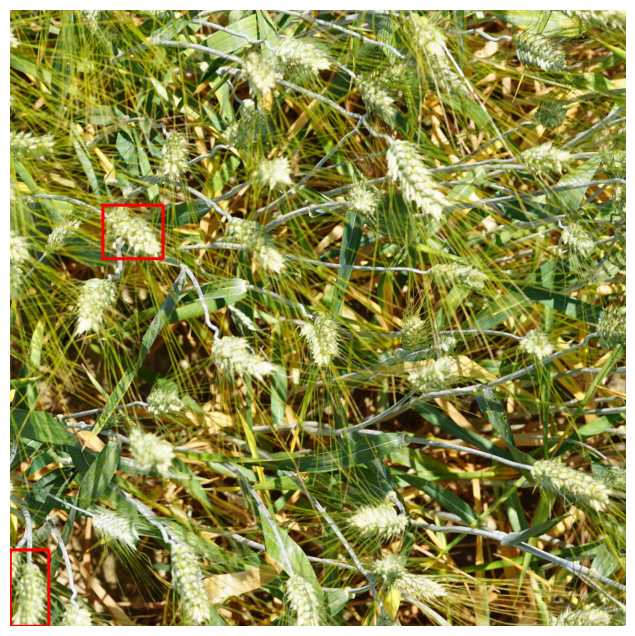

In [72]:
images, targets, image_ids = next(iter(train_data_loader))
# images = list(image.to(device) for image in images)
# targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

boxes = targets[4]['boxes'].cpu().numpy().astype(np.int32)
sample = images[4].permute(1, 2, 0).cpu().numpy()

sample = sample.copy()

fig, ax = plt.subplots(1, 1, figsize=(16, 8))

for box in boxes:
    cv2.rectangle(sample,
                  (box[0], box[1]),
                  (box[2], box[3]),
                  (220, 0, 0), 3)

ax.set_axis_off()
ax.imshow(sample)


# 3.Finetuuning the model

### Defining the model

Faster R-CNN is a model that predicts both bounding boxes and class scores for potential objects in the image.
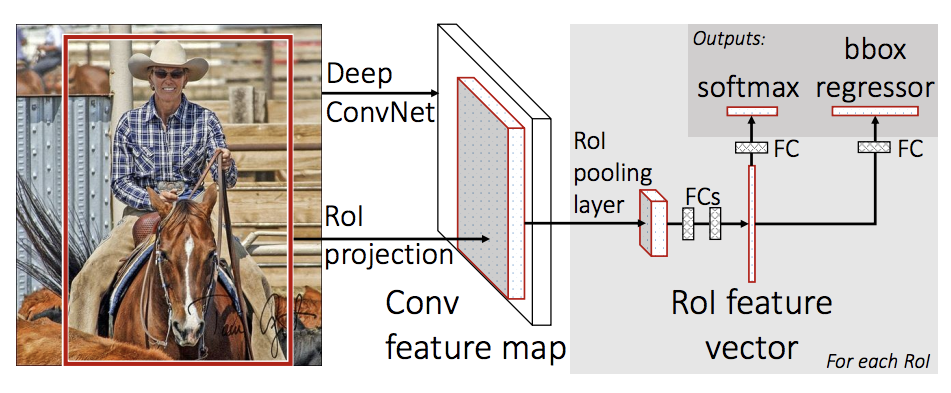


Let’s explain how this architecture works, Faster RCNN is composed from 3 parts

1. Part 1 : Convolution layers : A CNN architecture is formed by a stack of distinct layers that transform the input volume into an output volume (e.g. holding the class scores) through a differentiable function.Convolutional networks were inspired by biological processes in that the connectivity pattern between neurons resembles the organization of the animal visual cortex. Individual cortical neurons respond to stimuli only in a restricted region of the visual field known as the receptive field. The receptive fields of different neurons partially overlap such that they cover the entire visual field.

2. Part 2 : Region Proposel Network (RPN) : RPN is small neural network sliding on the last feature map of the convolution layers and predict wether there is an object or not and also predict the bounding box of those objects.

3. Part 3 : Classes and Bounding Boxes prediction : Now we use another Fully connected neural networks that takes as an inpt the regions proposed by the RPN and predict object class ( classification) and Bounding boxes (Regression).

*There are two common situations where one might want to modify one of the available models in torchvision modelzoo. The first is when we want to start from a pre-trained model, and just finetune the last layer. The other is when we want to replace the backbone of the model with a different one . In our case, we want to fine-tune from a pre-trained model, given that our dataset is very small, so we will be following approach number first.*

In [13]:
# load a model; pre-trained on COCO
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=False, pretrained_backbone=False)

C:\Users\allex\miniconda3\envs\PyTorchTest\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\allex\miniconda3\envs\PyTorchTest\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
C:\Users\allex\miniconda3\envs\PyTorchTest\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained_backbone' is deprecated since 0.13 and may be removed in the future, please use 'weights_backbone' instead.
  warnings.warn(
C:\Users\allex\miniconda3\envs\PyTorchTest\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights_backbone' are deprecated

One note on the labels. The model considers class 0 as background. If your dataset does not contain the background class, you should not have 0 in your labels. For example, assuming you have just two classes, cat and dog, you can define 1 (not 0) to represent cats and 2 to represent dogs. So, for instance, if one of the images has booth classes, your labels tensor should look like [1,2].

In our case number of classes are 2, class 0 for background and class 1 for wheat.

In [74]:
print(model)

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
       

In [14]:
num_classes = 2  # 1 class (wheat) + background

# get number of input features for the classifier
in_features = model.roi_heads.box_predictor.cls_score.in_features

# replace the pre-trained head with a new one
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

# Load the trained weights
model.load_state_dict(torch.load(WEIGHTS_FILE))  ##Load pre trained weights
#model.eval()

#x = model.to(device)

<All keys matched successfully>

In [76]:
print(model)

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
       

### Lets train our model

In [15]:
print(train_data_loader.__len__())

170


In [19]:
import time

model.train()
model.to(device)
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.01, momentum=0.9, weight_decay=0.00001)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.5)
#lr_scheduler = None

num_epochs = 1

loss_hist = Averager()

itr = 1
for epoch in range(num_epochs):
    start = time.time()
    loss_hist.reset()

    for images, targets, image_ids in train_data_loader:

        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        loss_dict = model(images, targets)  ##Return the loss

        losses = sum(loss for loss in loss_dict.values())
        loss_value = losses.item()

        loss_hist.send(loss_value)  #Average out the loss

        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

        if itr % 10 == 0:
            end = time.time()
            print(f"Iteration #{itr} loss: {loss_value:.3f} time:{end-start}s")
            start = time.time()

        itr += 1

    # update the learning rate
    if lr_scheduler is not None:
        lr_scheduler.step()

    print(f"Epoch #{epoch} loss: {loss_hist.value}")

Iteration #10 loss: 1.0227524042129517
Iteration #20 loss: 1.0426664352416992
Iteration #30 loss: 0.9292507767677307
Iteration #40 loss: 0.8961747884750366
Iteration #50 loss: 0.985585629940033
Iteration #60 loss: 0.907809853553772
Iteration #70 loss: 0.9393864870071411
Iteration #80 loss: 0.8573269248008728
Iteration #90 loss: 1.286327838897705
Iteration #100 loss: 0.863779604434967
Iteration #110 loss: 0.6827918291091919
Iteration #120 loss: 0.7675857543945312
Iteration #130 loss: 0.7095056176185608
Iteration #140 loss: 1.0850749015808105
Iteration #150 loss: 0.7391904592514038
Iteration #160 loss: 0.8084866404533386
Iteration #170 loss: 0.6904568076133728
Epoch #0 loss: 0.9373910283341127
Iteration #180 loss: 0.8035903573036194
Iteration #190 loss: 1.0452989339828491
Iteration #200 loss: 0.8973376750946045
Iteration #210 loss: 0.8633445501327515
Iteration #220 loss: 0.9834625720977783
Iteration #230 loss: 0.8776549100875854
Iteration #240 loss: 0.8897298574447632
Iteration #250 loss

# 4. Prediction

### Lets load the test data

In [20]:
test_dataset = WheatDataset(submit, test_dir, trans, False)

In [21]:
test_data_loader = DataLoader(test_dataset, batch_size=8, shuffle=False)  ##Test dataloader

### Set the threshold value for predicting bounding box.

In [22]:
detection_threshold = 0.45

In [23]:
def format_prediction_string(boxes, scores):  ## Define the formate for storing prediction results
    pred_strings = []
    for j in zip(scores, boxes):
        pred_strings.append("{0:.4f} {1} {2} {3} {4}".format(j[0], j[1][0], j[1][1], j[1][2], j[1][3]))

    return " ".join(pred_strings)

In [24]:
## Lets make the prediction
results = []
model.eval()
# outputs = None
# images = None
for images, image_ids in test_data_loader:

    images = list(image.to(device) for image in images)
    outputs = model(images)

    for i, image in enumerate(images):
        boxes = outputs[i]['boxes'].data.cpu().numpy()  ##Formate of the output's box is [Xmin,Ymin,Xmax,Ymax]
        scores = outputs[i]['scores'].data.cpu().numpy()

        boxes = boxes[scores >= detection_threshold].astype(np.int32)  #Compare the score of output with the threshold and
        scores = scores[scores >= detection_threshold]  # select only those boxes whose score is greater than threshold value
        image_id = image_ids[i]

        boxes[:, 2] = boxes[:, 2] - boxes[:, 0]
        boxes[:, 3] = boxes[:, 3] - boxes[:, 1]  #Convert the box formate to [Xmin,Ymin,W,H]

        result = {  #Store the image id and boxes and scores in result dict.
            'image_id': image_id,
            'PredictionString': format_prediction_string(boxes, scores)
        }

        results.append(result)  #Append the result dict to Results list

In [25]:
test_df = pd.DataFrame(results, columns=['image_id', 'PredictionString'])
test_df.head()

,image_id,PredictionString
0,aac893a91,0.9947 613 912 78 110 0.9847 740 767 76 116 0....
1,51f1be19e,0.9932 609 79 161 180 0.9796 768 873 146 106 0...
2,f5a1f0358,0.9769 688 199 111 92 0.9757 154 241 77 89 0.9...
3,796707dd7,0.9494 505 780 87 97 0.9465 712 822 109 98 0.9...
4,51b3e36ab,0.9943 235 638 91 160 0.9937 364 148 100 97 0....


In [35]:
images

[tensor([[[0.1529, 0.1608, 0.1647,  ..., 0.7647, 0.7098, 0.6549],
          [0.1529, 0.1569, 0.1608,  ..., 0.7333, 0.6745, 0.6314],
          [0.1608, 0.1647, 0.1647,  ..., 0.6941, 0.6588, 0.6314],
          ...,
          [0.1569, 0.1686, 0.1765,  ..., 0.8902, 0.8941, 0.8941],
          [0.1490, 0.1686, 0.2039,  ..., 0.8941, 0.8902, 0.8824],
          [0.1451, 0.1725, 0.2157,  ..., 0.8902, 0.8824, 0.8706]],
 
         [[0.0863, 0.0941, 0.0980,  ..., 0.6157, 0.5608, 0.5059],
          [0.0863, 0.0902, 0.0941,  ..., 0.5804, 0.5255, 0.4824],
          [0.0941, 0.0980, 0.0980,  ..., 0.5333, 0.4980, 0.4784],
          ...,
          [0.0941, 0.0980, 0.1020,  ..., 0.6706, 0.6706, 0.6784],
          [0.0824, 0.0980, 0.1176,  ..., 0.6706, 0.6667, 0.6667],
          [0.0784, 0.1020, 0.1294,  ..., 0.6667, 0.6588, 0.6549]],
 
         [[0.0471, 0.0549, 0.0588,  ..., 0.3686, 0.3137, 0.2588],
          [0.0471, 0.0510, 0.0549,  ..., 0.3255, 0.2706, 0.2275],
          [0.0549, 0.0588, 0.0588,  ...,

In [33]:
sample = images[1].permute(1, 2, 0).cpu().numpy()
sample = sample.copy()
boxes = outputs[1]['boxes'].data.cpu().numpy()
scores = outputs[1]['scores'].data.cpu().numpy()

boxes = boxes[scores >= detection_threshold].astype(np.int32)

### Lets plot some of our prediction

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


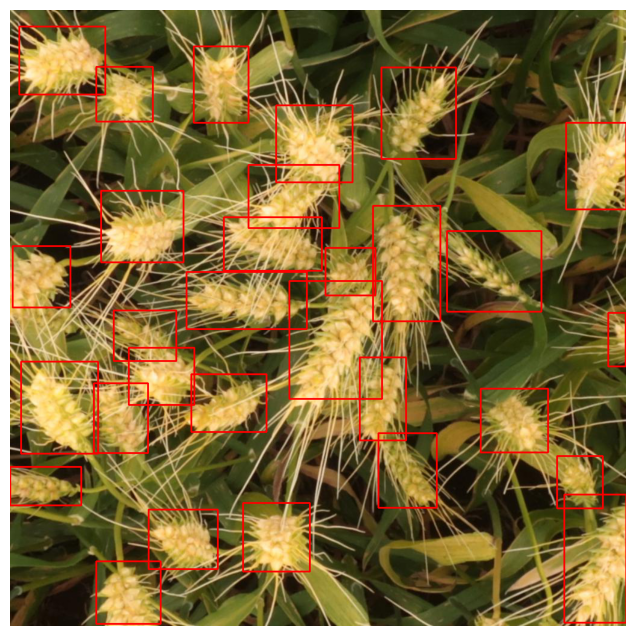

In [34]:
fig, ax = plt.subplots(1, 1, figsize=(16, 8))

for box in boxes:
    cv2.rectangle(sample,
                  (box[0], box[1]),
                  (box[2], box[3]),
                  (220, 0, 0), 2)

ax.set_axis_off()
ax.imshow(sample)

## Submission

In [ ]:
test_df.to_csv('submission.csv', index=False)

In [36]:
torch.save(model.state_dict(), "models/fastercnn_resnet50_3epochs_grau")